In [29]:
import cv2
import numpy as np
import tkinter as tk
from tkinter import filedialog
from PIL import Image, ImageTk, ImageDraw

# --- Resize function ---
def resize_to_fit(image, max_width=1200, max_height=800):   # we are putting image and sizes as parameetrs
    height, width = image.shape[:2]   # extractung the height and width of image.
    if width > max_width or height > max_height:   # this will compare with the paraemters we passed, in case condition is true
        scale = min(max_width / width, max_height / height)   # amoing the two we will choose teh smaller one 
        new_width = int(width * scale)                       # then multiply the one we get with actual dimension of image
        new_height = int(height * scale)
        return cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_AREA)
    return image


# If we are resizing our image to be be big, then interpolation will estimate the value of new pixels to fill in the gap. But this wont expand the brighter 
# section of image only like dilation.

# --- Cartoonizing function  has theree sections.
# It smooth the image color region.
# Enhanvce the edges
# then combine both.


# in below where we  are passing median blur etc these are default valyes in case if we dont pass any parameter.

def cartoonize(image_path, median_blur_ksize=5, adaptive_block_size=5):    # blyr size kernal is for smoothning/ noise reduction, # adpative -> edge detct
    image = cv2.imread(image_path)
    if image is None:
        return None

    image = resize_to_fit(image)   # we are calling our resize function.

    for _ in range(3):      # here we are applying the same median blur kernal three times
        image = cv2.medianBlur(image, median_blur_ksize)

    filtered = cv2.bilateralFilter(image, 5, 100, 100)  # then we are applying to smooth image but preseerves edges.

# now we are doing unsharp masking: Blur the image,  subtract the blurred version from the original, when get edges/high-frequency image,
# add that back to sharpen.

    gaussian = cv2.GaussianBlur(filtered, (11, 11), 15)   # now after preserving the image we are again 
    sharp = cv2.addWeighted(filtered, 1.5, gaussian, -0.5, 0)
    sharp = cv2.addWeighted(sharp, 1.4, gaussian,- 0.2, 10)

    gray = cv2.cvtColor(sharp, cv2.COLOR_BGR2GRAY)  # converting this to gray scale for edge detcetion
    block_size = adaptive_block_size if adaptive_block_size % 2 == 1 else adaptive_block_size + 1
    block_size = max(block_size, 3)
    edges = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY, block_size, 5) 

#  cv2.ADAPTIVE_THRESH_MEAN_C: The threshold for a pixel is the mean of neighboring pixels minus C (which is 3 here).
#a larger number is subtracted from the local mean (i.e., if you increase C), it makes the threshold stricter, meaning fewer pixels will have a value greater than (local mean - C).
# This means: Fewer pixels will meet the condition of being greater than (local mean - C), so fewer pixels will be considered as edges.
# Pixels above threshold become white (255), below become black (0).


#Filtered (filtered) emphasizes details and edges, so increasing its weight makes the image look more sharp and defined.

# Gaussian (gaussian) emphasizes smoothness and blurring, so increasing its weight makes the image look more soft and paint-like.


# if we are taking positive weights of gussain filter are actually adding the blurred one into fileted one wth sharper features, 
#The result of additionof both is that details or sharper one are convolved in smoother pic so instead of pic with edges highlighted we are making an 
#image that is smootha nd soft with no edges highligted.

# When we are having negative weights of Gusasian we are actually subytracting teh blutr oart from noth the filtered one and gussan .
# As a result we are obtaining a pic with the edges one.
    edges = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)

    cartoon = cv2.bitwise_and(sharp, edges)
# flat color + strong outline = cartoon
    return cartoon

# --- Upload and display ---
def upload_image(): 
    global current_image_path # it will store teh path of image , we can access it outside the function too
    file_path = filedialog.askopenfilename(filetypes=[("Image files", "*.jpg *.jpeg *.png *.bmp")]) # onlhy these files vam be choosen
    if file_path:  # it checks if we actually sleeted a file. like if we cancel the pop up of  upload file, then this wont wel.
        current_image_path = file_path  # we are storing our path in global variable
        update_display()   # here we are calling another function

def update_display(*args):   # args allows us to pass many number of arugumenst
    if not current_image_path: # it checks if we have an image path or no. if no then exits the funcstion
        return

    median = blending_slider.get()   # this is valling blending slider so we can put outr vlaye which will be stored in this variable , use in function
    block_size = smooth_slider.get()  # similar as above but this one is for edge

    cartoon = cartoonize(current_image_path, median, block_size)  # this is calling the cartoonuze function withour passed variables value
    if cartoon is None:
        return

    rgb = cv2.cvtColor(cartoon, cv2.COLOR_BGR2RGB)  # because of library compatibilities we are chnaging image from BGR to RGB
    img_pil = Image.fromarray(rgb) # convert  the numpy array (rgb) into a PIL image object, which is compatible with GUI libraries like Tkinter.



    img_pil.thumbnail((800, 800), Image.Resampling.LANCZOS)  # lanczos us used for hifher display of image . We are setting image size of display 800
    img_tk = ImageTk.PhotoImage(img_pil)  # again converting for Tkinter-compatible forma
 
    label_img.config(image=img_tk)  # 
    label_img.image = img_tk

#2nd last line :  In Python, if a variable is not used anywhere, it gets garbage collected ,deleted from memory to save space.
# Tkinter doesn’t automatically hold a reference to the image — so if we don’t manually store it like this, the image disappears (nothing shows on screen!).


# rounded button ---
def create_rounded_button(parent, text, command, bg_color="#C8A2C8", fg_color="white", radius=20):
    img = Image.new("RGBA", (150, 40), (0, 0, 0, 0))   # we are creating a new image of ransparent background)
    draw = ImageDraw.Draw(img)  
    draw.rounded_rectangle((0, 0, 150, 40), radius=radius, fill=bg_color) # now we are drawing a simple rectabgle 
    btn_img = ImageTk.PhotoImage(img)  # now this image is converted into a format that tinker can display

# creating a widget for butten, 
    btn = tk.Label(parent, image=btn_img, text=text, compound="center",fg=fg_color, font=("Arial", 12, "bold"), cursor="hand2")
    btn.image = btn_img  # keepinga  reference so it doenst disappear
    btn.bind("<Button-1>", lambda e: command())
    return btn  # returned so it can be placed in the parent widget.

# GUI Setup ---

# we are creating a tinker video and settingits title and size 
window = tk.Tk()
window.title("Cartoonizer GUI")
window.geometry("1200x800")

try:
    bg_image = Image.open(r"C:\Users\PMLS\Downloads\download (11).jpg").resize((1200, 800)) # laoding the image to show as our baclground
    bg_display = ImageTk.PhotoImage(bg_image) # loading it in a way tinker canw ork with 
    bg_label = tk.Label(window, image=bg_display) 
    bg_label.place(x=0, y=0, relwidth=1, relheight=1) # defining the area background image will cover
    window.bg_display = bg_display # reference 
except Exception as e:
    print(f"Error loading background image: {e}")
    window.config(bg="lightgray")  # if there is no background image set this color as background

btn_upload = create_rounded_button(window, "Upload Image", upload_image)  # here we are creating our button
btn_upload.pack(pady=10)

# --- Horizontal Sliders Frame ---
sliders_frame = tk.Frame(window, bg="lightgray") # creating a frame strcture in our main tk fram that will contain slider
sliders_frame.pack(pady=10)  # giving space above and below of 10 

# Blending Slider
blend_frame = tk.Frame(sliders_frame, bg="lightgray")  # a nested frame inside slider frame, baclgrouynf color
blend_frame.pack(side=tk.LEFT, padx=30)  # present on left side of slider frame, 30 pixel difference between neighbour slider 
tk.Label(blend_frame, text="Blending Level", bg="#C8A2C8", fg="white", font=("Arial", 10, "bold")).pack()

# giving name, color, and font size, style,  pack means its presnet inside blendframe

blending_slider = tk.Scale(blend_frame, from_=3, to=21, resolution=2, orient="horizontal", length=200, bg="#EEE", troughcolor="#C8A2C8",
                           highlightthickness=0, command=update_display)
# range of values slider can take 3 - 21,  slider moves in steps of 2 (e.g., 3, 5, 7) , present horizently, lenght is 200 pixels, color, trough = 
# area where slider mofes, highlight thicknesd =   outline around the slider when it's focused.
# update_display is called every time the slider value changes.
 
blending_slider.set(5) # initial value of the blending slider to 5 when the application starts.
blending_slider.pack() # ppcks it inside the blend frame so its visible

# Edge Detection Slider
edge_frame = tk.Frame(sliders_frame, bg="lightgray")
edge_frame.pack(side=tk.LEFT, padx=30)
tk.Label(edge_frame, text="Edge Level", bg="#C8A2C8", fg="white", font=("Arial", 10, "bold")).pack()
smooth_slider = tk.Scale(edge_frame, from_=3, to=21, resolution=2, orient="horizontal",
                         length=200, bg="#EEE", troughcolor="#C8A2C8",
                         highlightthickness=0, command=update_display)
smooth_slider.set(5)
smooth_slider.pack()

# Image display
label_img = tk.Label(window)
label_img.pack(pady=10)

current_image_path = None

window.mainloop()

#  Without calling mainloop(), your window would open and immediately close because the script would reach its end. 
# Calling mainloop() keeps the window open, allowing the user to interact with it.



In [27]:
import cv2
import numpy as np
import tkinter as tk
from tkinter import filedialog
from PIL import Image, ImageTk, ImageDraw

# --- Resize function ---
def resize_to_fit(image, max_width=1200, max_height=800):   # we are putting image and sizes as parameetrs
    height, width = image.shape[:2]   # extractung the height and width of image.
    if width > max_width or height > max_height:   # this will compare with the paraemters we passed, in case condition is true
        scale = min(max_width / width, max_height / height)   # amoing the two we will choose teh smaller one 
        new_width = int(width * scale)                       # then multiply the one we get with actual dimension of image
        new_height = int(height * scale)
        return cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_AREA)
    return image


def cartoonize(image_path, median_blur_ksize=5, adaptive_block_size=5):    # blyr size kernal is for smoothning/ noise reduction, # adpative -> edge detct
    image = cv2.imread(image_path)
    if image is None:
        return None

    image = resize_to_fit(image)   # we are calling our resize function.

    for _ in range(3):      # here we are applying the same median blur kernal three times
        image = cv2.medianBlur(image, median_blur_ksize)

    filtered = cv2.bilateralFilter(image, 5, 100, 100)  # then we are applying to smooth image but preseerves edges.

    gaussian = cv2.GaussianBlur(filtered, (11, 11), 15)   # now after preserving the image we are again 
    sharp = cv2.addWeighted(filtered, 1.5, gaussian, -0.5, 0)
    sharp = cv2.addWeighted(sharp, 1.4, gaussian,- 0.2, 10)

    gray = cv2.cvtColor(sharp, cv2.COLOR_BGR2GRAY)  # converting this to gray scale for edge detcetion
    block_size = adaptive_block_size if adaptive_block_size % 2 == 1 else adaptive_block_size + 1
    block_size = max(block_size, 3)
    edges = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY, block_size, 5) 

    edges = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)

    cartoon = cv2.bitwise_and(sharp, edges)
# flat color + strong outline = cartoon
    return cartoon

# --- Upload and display ---
def upload_image(): 
    global current_image_path # it will store teh path of image , we can access it outside the function too
    file_path = filedialog.askopenfilename(filetypes=[("Image files", "*.jpg *.jpeg *.png *.bmp")]) # onlhy these files vam be choosen
    if file_path:  # it checks if we actually sleeted a file. like if we cancel the pop up of  upload file, then this wont wel.
        current_image_path = file_path  # we are storing our path in global variable
        update_display()   # here we are calling another function

def update_display(*args):   # args allows us to pass many number of arugumenst
    if not current_image_path: # it checks if we have an image path or no. if no then exits the funcstion
        return

    median = blending_slider.get()   # this is valling blending slider so we can put outr vlaye which will be stored in this variable , use in function
    block_size = smooth_slider.get()  # similar as above but this one is for edge

    cartoon = cartoonize(current_image_path, median, block_size)  # this is calling the cartoonuze function withour passed variables value
    if cartoon is None:
        return

    rgb = cv2.cvtColor(cartoon, cv2.COLOR_BGR2RGB)  # because of library compatibilities we are chnaging image from BGR to RGB
    img_pil = Image.fromarray(rgb) # convert  the numpy array (rgb) into a PIL image object, which is compatible with GUI libraries like Tkinter.



    img_pil.thumbnail((800, 800), Image.Resampling.LANCZOS)  # lanczos us used for hifher display of image . We are setting image size of display 800
    img_tk = ImageTk.PhotoImage(img_pil)  # again converting for Tkinter-compatible forma
 
    label_img.config(image=img_tk)  # 
    label_img.image = img_tk

# rounded button ---
def create_rounded_button(parent, text, command, bg_color="#C8A2C8", fg_color="white", radius=20):
    img = Image.new("RGBA", (150, 40), (0, 0, 0, 0))   # we are creating a new image of ransparent background)
    draw = ImageDraw.Draw(img)  
    draw.rounded_rectangle((0, 0, 150, 40), radius=radius, fill=bg_color) # now we are drawing a simple rectabgle 
    btn_img = ImageTk.PhotoImage(img)  # now this image is converted into a format that tinker can display

# creating a widget for butten, 
    btn = tk.Label(parent, image=btn_img, text=text, compound="center",fg=fg_color, font=("Arial", 12, "bold"), cursor="hand2")
    btn.image = btn_img  # keepinga  reference so it doenst disappear
    btn.bind("<Button-1>", lambda e: command())
    return btn  # returned so it can be placed in the parent widget.

# GUI Setup ---

# we are creating a tinker video and settingits title and size 
window = tk.Tk()
window.title("Cartoonizer GUI")
window.geometry("1200x800")

try:
    bg_image = Image.open(r"C:\Users\PMLS\Downloads\download (11).jpg").resize((1200, 800)) # laoding the image to show as our baclground
    bg_display = ImageTk.PhotoImage(bg_image) # loading it in a way tinker canw ork with 
    bg_label = tk.Label(window, image=bg_display) 
    bg_label.place(x=0, y=0, relwidth=1, relheight=1) # defining the area background image will cover
    window.bg_display = bg_display # reference 
except Exception as e:
    print(f"Error loading background image: {e}")
    window.config(bg="lightgray")  # if there is no background image set this color as background

btn_upload = create_rounded_button(window, "Upload Image", upload_image)  # here we are creating our button
btn_upload.pack(pady=10)

# --- Horizontal Sliders Frame ---
sliders_frame = tk.Frame(window, bg="lightgray") # creating a frame strcture in our main tk fram that will contain slider
sliders_frame.pack(pady=10)  # giving space above and below of 10 

# Blending Slider
blend_frame = tk.Frame(sliders_frame, bg="lightgray")  # a nested frame inside slider frame, baclgrouynf color
blend_frame.pack(side=tk.LEFT, padx=30)  # present on left side of slider frame, 30 pixel difference between neighbour slider 
tk.Label(blend_frame, text="Blending Level", bg="#C8A2C8", fg="white", font=("Arial", 10, "bold")).pack()


blending_slider = tk.Scale(blend_frame, from_=3, to=21, resolution=2, orient="horizontal", length=200, bg="#EEE", troughcolor="#C8A2C8",
                           highlightthickness=0, command=update_display)

 
blending_slider.set(5) # initial value of the blending slider to 5 when the application starts.
blending_slider.pack() # ppcks it inside the blend frame so its visible

# Edge Detection Slider
edge_frame = tk.Frame(sliders_frame, bg="lightgray")
edge_frame.pack(side=tk.LEFT, padx=30)
tk.Label(edge_frame, text="Edge Level", bg="#C8A2C8", fg="white", font=("Arial", 10, "bold")).pack()
smooth_slider = tk.Scale(edge_frame, from_=3, to=21, resolution=2, orient="horizontal",
                         length=200, bg="#EEE", troughcolor="#C8A2C8",
                         highlightthickness=0, command=update_display)
smooth_slider.set(5)
smooth_slider.pack()

# Image display
label_img = tk.Label(window)
label_img.pack(pady=10)

current_image_path = None

window.mainloop()




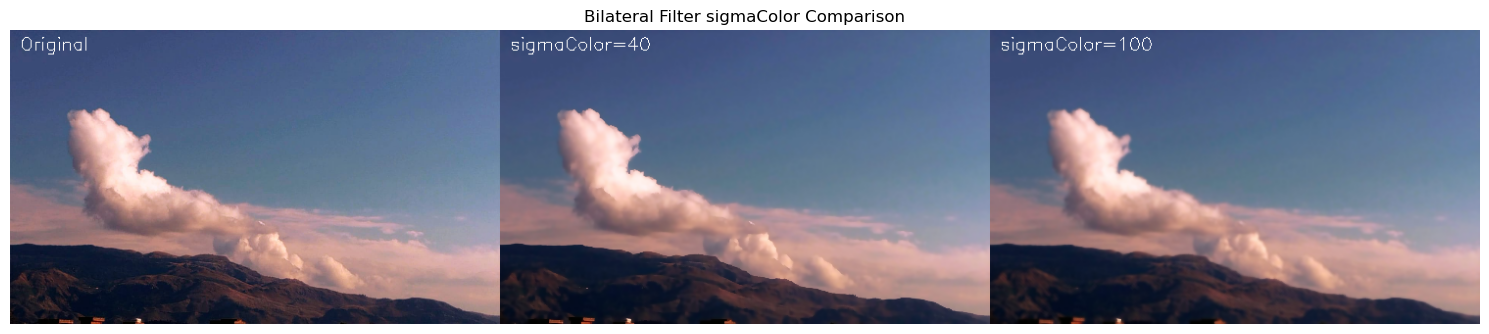

In [13]:
import cv2
import numpy as np
import tkinter as tk
from tkinter import filedialog
from PIL import Image, ImageTk, ImageDraw

# --- Resize function ---
def resize_to_fit(image, max_width=1200, max_height=800):
    height, width = image.shape[:2]
    if width > max_width or height > max_height:
        scale = min(max_width / width, max_height / height)
        new_width = int(width * scale)
        new_height = int(height * scale)
        return cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_AREA)
    return image

# --- Cartoonize Function ---
def cartoonize(image_path, median_blur_ksize=5, adaptive_block_size=5):
    image = cv2.imread(image_path)
    if image is None:
        return None

    image = resize_to_fit(image)
    for _ in range(3):
        image = cv2.medianBlur(image, median_blur_ksize)

    filtered = cv2.bilateralFilter(image, 5, 100, 100)
    gaussian = cv2.GaussianBlur(filtered, (11, 11), 15)
    sharp = cv2.addWeighted(filtered, 1.5, gaussian, -0.5, 0)
    sharp = cv2.addWeighted(sharp, 1.4, gaussian, -0.2, 10)

    gray = cv2.cvtColor(sharp, cv2.COLOR_BGR2GRAY)
    block_size = adaptive_block_size if adaptive_block_size % 2 == 1 else adaptive_block_size + 1
    block_size = max(block_size, 3)
    edges = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                                   cv2.THRESH_BINARY, block_size, 5)

    edges = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)
    cartoon = cv2.bitwise_and(sharp, edges)
    return cartoon

# --- Upload Image ---
def upload_image():
    global current_image_path
    file_path = filedialog.askopenfilename(filetypes=[("Image files", "*.jpg *.jpeg *.png *.bmp")])
    if file_path:
        current_image_path = file_path
        update_display()

# --- Update Display ---
def update_display(*args):
    if not current_image_path:
        return

    median = blending_slider.get()
    block_size = smooth_slider.get()
    cartoon = cartoonize(current_image_path, median, block_size)

    if cartoon is None:
        return

    rgb = cv2.cvtColor(cartoon, cv2.COLOR_BGR2RGB)
    img_pil = Image.fromarray(rgb)
    img_pil.thumbnail((800, 800), Image.Resampling.LANCZOS)
    img_tk = ImageTk.PhotoImage(img_pil)

    label_img.config(image=img_tk)
    label_img.image = img_tk

# --- Create Rounded Button ---
def create_rounded_button(parent, text, command, bg_color="#8A2BE2", fg_color="white", radius=20):
    img = Image.new("RGBA", (160, 45), (0, 0, 0, 0))
    draw = ImageDraw.Draw(img)
    draw.rounded_rectangle((0, 0, 160, 45), radius=radius, fill=bg_color)
    btn_img = ImageTk.PhotoImage(img)

    btn = tk.Label(parent, image=btn_img, text=text, compound="center", fg=fg_color,
                   font=("Segoe UI", 12, "bold"), cursor="hand2", bg="white")
    btn.image = btn_img
    btn.bind("<Enter>", lambda e: btn.config(fg="yellow"))
    btn.bind("<Leave>", lambda e: btn.config(fg=fg_color))
    btn.bind("<Button-1>", lambda e: command())
    return btn

# --- GUI Setup ---
window = tk.Tk()
window.title("Cartoonizer GUI")
window.geometry("1200x800")
window.resizable(False, False)

# --- Background ---
try:
    bg_image = Image.open(r"C:\Users\PMLS\Downloads\download (11).jpg").resize((1200, 800))
    bg_display = ImageTk.PhotoImage(bg_image)
    bg_label = tk.Label(window, image=bg_display)
    bg_label.place(x=0, y=0, relwidth=1, relheight=1)
    window.bg_display = bg_display
except Exception as e:
    print(f"Error loading background image: {e}")
    window.config(bg="lightgray")

# --- Upload Button ---
btn_upload = create_rounded_button(window, "Upload Image", upload_image)
btn_upload.place(relx=0.5, y=20, anchor="n")

# --- Sliders Frame ---
sliders_frame = tk.Frame(window, bg="white", bd=2, relief="ridge")
sliders_frame.place(relx=0.5, y=80, anchor="n")

# --- Blending Slider ---
blend_frame = tk.Frame(sliders_frame, bg="white")
blend_frame.grid(row=0, column=0, padx=40, pady=10)
tk.Label(blend_frame, text="Blending Level", bg="#8A2BE2", fg="white",
         font=("Segoe UI", 10, "bold"), width=20).pack(pady=5)

blending_slider = tk.Scale(blend_frame, from_=3, to=21, resolution=2, orient="horizontal",
                           length=200, bg="#EEE", troughcolor="#8A2BE2", highlightthickness=0,
                           command=update_display)
blending_slider.set(5)
blending_slider.pack()

# --- Edge Detection Slider ---
edge_frame = tk.Frame(sliders_frame, bg="white")
edge_frame.grid(row=0, column=1, padx=40, pady=10)
tk.Label(edge_frame, text="Edge Level", bg="#8A2BE2", fg="white",
         font=("Segoe UI", 10, "bold"), width=20).pack(pady=5)

smooth_slider = tk.Scale(edge_frame, from_=3, to=21, resolution=2, orient="horizontal",
                         length=200, bg="#EEE", troughcolor="#8A2BE2", highlightthickness=0,
                         command=update_display)
smooth_slider.set(5)
smooth_slider.pack()

# --- Image Display ---
label_img = tk.Label(window, bg="white", bd=3, relief="sunken")
label_img.place(relx=0.5, rely=0.45, anchor="n")

current_image_path = None
window.mainloop()
